### LTV Model 
* Datasets: Viewership, Online Content, Subscription, Demographic
* Brand: All 5 Linear Brands
* Feature window: 2024-01-01 to 2024-06-30
* LTV Label/Churn Window: 2024-07-01 to 2024-12-31

In [5]:
!pip install xgboost
!pip install shap
!pip install numpy==2.1

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap

In [7]:
demo_df = pd.read_csv('Datasets/demo_data.csv')
onlinecontent_df = pd.read_csv('Datasets/onlinecontent_data.csv')
viewership_df = pd.read_csv('Datasets/viewership_data.csv')


In [8]:
seed = 23
# online content filter score threshold
score_threshold = 0.2

train_start, train_end = '2024-01-01','2024-06-30'
val_start, val_end = '2024-07-01','2024-12-31'

### Online Content EDA

In [9]:
# Remove punctuation from the 'Show Name' column
viewership_df['Show Name'] = viewership_df['Show Name'].str.replace(r"[^\w\s]", "", regex=True)

# Capitalize the first letter of every word
viewership_df['Show Name'] = viewership_df['Show Name'].str.title()

In [10]:
def extract_show_name(url):
    # Extract the part after the last slash
    last_part = url.split('/')[-1]
    
    # Remove trailing season or preview patterns
    # This regex removes "-season-" followed by digits or "-preview"
    last_part = re.sub(r'(-season-\d+|-preview|-episode|-exclusive|-special|-free|-new|-guide|-trial)', '', last_part, flags=re.IGNORECASE)
    # Check if there is a '?' in the show name and split if it exists
    if '?' in last_part:
        last_part = last_part.split('?')[0]
    # Replace hyphens with spaces, strip extra spaces, and title-case the result
    show_name = last_part.replace('-', ' ').strip().title()
    return show_name

# Apply the function to create a new column 'Show Name'
onlinecontent_df['Show Name'] = onlinecontent_df['URL'].apply(extract_show_name)
# Replace the specific value in the 'Show Name' column
onlinecontent_df['Show Name'] = onlinecontent_df['Show Name'].replace('Retro Sci Fi Space And Beyond', 'Retro Scifi Space And Beyond')

In [11]:
# Remove rows where SCORE is less than 0.2
onlinecontent_df = onlinecontent_df[onlinecontent_df['SCORE'] >= score_threshold]

unique_pairs = viewership_df[['Show Name', 'Network']].drop_duplicates()
duplicate_show_names = unique_pairs.groupby('Show Name').filter(lambda x: len(x) > 1)
paid_network = ['Pulse', 'Lime Light', 'ChillStream', 'RetroReel', 'CineQuest']

# Create a mask for duplicate show names
mask = unique_pairs['Show Name'].isin(duplicate_show_names['Show Name']) & ~unique_pairs['Network'].isin(paid_network)
# Filter out the rows
filtered_unique_pairs = unique_pairs[~mask]
onlinecontent_df = onlinecontent_df.merge(filtered_unique_pairs, on='Show Name', how='left')
onlinecontent_df = onlinecontent_df.dropna()
onlinecontent_df['DATE'] = pd.to_datetime(onlinecontent_df['DATE'])
onlinecontent_df

,Capstone_id,DATE,URL,SCORE,Show Name,Network
0,WLB4760714,2024-09-05,www.streamit.net/target-locked-season-1,0.249421,Target Locked,Pulse
2,ULS3093658,2024-01-10,watch.streamit.net/hollywood-gold-the-best-of-...,0.493832,Hollywood Gold The Best Of The Silver Screen,RetroReel
3,LTU2671262,2024-10-14,hub.example.com/flight-risk-exclusive,0.715998,Flight Risk,Pulse
4,OBU8620262,2024-04-16,hub.streamit.net/deep-waters-submarine-showdow...,0.777658,Deep Waters Submarine Showdown,Pulse
6,PYB6401649,2024-03-27,hub.myshow.tv/highway-heist-season-1,0.617985,Highway Heist,Pulse
...,...,...,...,...,...,...
839598,AOM2547859,2024-09-23,stream.watchhub.org/the-lost-dynasty-preview,0.677991,The Lost Dynasty,HistoryWatch
839599,HWK3212535,2024-06-01,www.streamit.net/unsolved-mysteries-season-1,0.408212,Unsolved Mysteries,DocuWorld
839600,BFT2716431,2024-10-24,www.streamit.net/hidden-civilizations-free-trial,0.234244,Hidden Civilizations,DocuWorld
839601,GKB8775130,2024-02-26,hub.streamit.net/operation-blackout-new,0.412139,Operation Blackout,ActionMax


In [12]:
def groupby_df_online(df, date):
    current_day = pd.to_datetime(date)
    
    # Group by 'ID' and 'NETWORK' to find the first and last watch dates
    df_watch_dates = df.groupby(['Capstone_id', 'Network'])['DATE'].agg(
        FIRST_WATCH_DATE='min',
        LAST_WATCH_DATE='max'
    ).reset_index()
    
    # Calculate 'TENURE' as the difference between last and first watch dates
    df_watch_dates['TENURE_online'] = (df_watch_dates['LAST_WATCH_DATE'] - df_watch_dates['FIRST_WATCH_DATE']).dt.days + 1
    # Calculate 'RECENCY' as the difference between current day and last watch date
    df_watch_dates['RECENCY_online'] = (current_day - df_watch_dates['LAST_WATCH_DATE']).dt.days
    
    # Group by 'ID' and 'NETWORK' to find the number of sessions as 'FREQUENCY'
    df_num_sessions = df.groupby(['Capstone_id', 'Network']).size().reset_index(name='FREQUENCY_online')
    
    # Merge all data into a final DataFrame
    df_final = pd.merge(df_watch_dates, df_num_sessions, on=['Capstone_id', 'Network'])
    
    df_final = df_final[['Capstone_id', 'Network', 'RECENCY_online', 'FREQUENCY_online', 'TENURE_online']]
    
    return df_final

In [13]:
online_train = onlinecontent_df[(onlinecontent_df['DATE'] >= train_start) & (onlinecontent_df['DATE'] <= train_end)]
online_train_final = groupby_df_online(online_train, train_end)

online_val = onlinecontent_df[(onlinecontent_df['DATE'] >= val_start) & (onlinecontent_df['DATE'] <= val_end)]
online_val_final = groupby_df_online(online_val, val_end)

### Viewership EDA

In [14]:
# Ensure the time columns are in datetime format
viewership_df['Time Started'] = pd.to_datetime(viewership_df['Time Started'])
viewership_df['Time Ended'] = pd.to_datetime(viewership_df['Time Ended'])

# Calculate watch time for each entry
viewership_df['Watch Minutes'] = (viewership_df['Time Ended'] - viewership_df['Time Started']).dt.total_seconds() / 60  # Convert to minutes

# filter Watch Minutes >= 6 mins
viewership_df = viewership_df[viewership_df['Watch Minutes'] >= 6]

# Create new columns for Year, Month, and Weekday
viewership_df['Year'] = viewership_df['Time Started'].dt.year
viewership_df['Month'] = viewership_df['Time Started'].dt.month
viewership_df['Weekday'] = viewership_df['Time Started'].dt.day_name() 

In [15]:
def groupby_df_view(df, date):
    current_day = pd.to_datetime(date)    
    # Group by 'ID' and 'NETWORK' to find the first and last watch dates
    df_watch_dates = df.groupby(['Capstone_id', 'Network'])['Time Started'].agg(
        FIRST_WATCH_DATE='min',
        LAST_WATCH_DATE='max'
    ).reset_index()
    
    # Calculate 'TENURE' as the difference between last and first watch dates
    df_watch_dates['TENURE_view'] = (df_watch_dates['LAST_WATCH_DATE'] - df_watch_dates['FIRST_WATCH_DATE']).dt.days + 1
    # Calculate 'RECENCY' as the difference between current day and last watch date
    df_watch_dates['RECENCY_view'] = (current_day - df_watch_dates['LAST_WATCH_DATE']).dt.days
    
    # Group by 'ID' and 'NETWORK' to find the number of sessions as 'FREQUENCY'
    df_num_sessions = df.groupby(['Capstone_id', 'Network']).size().reset_index(name='FREQUENCY_view')
    
    # Group by 'ID' and 'NETWORK' to find the sum of duration
    df_sum_duration = df.groupby(['Capstone_id', 'Network'])['Watch Minutes'].sum().reset_index(name='TOTAL_WATCH_view')
    
    # Merge all data into a final DataFrame
    df_final = pd.merge(df_watch_dates, df_num_sessions, on=['Capstone_id', 'Network'])
    df_final = pd.merge(df_final, df_sum_duration, on=['Capstone_id', 'Network'])
    
    df_final = df_final[['Capstone_id', 'Network', 'RECENCY_view', 'FREQUENCY_view', 'TENURE_view', 'TOTAL_WATCH_view']]
    
    return df_final

In [16]:
view_train = viewership_df[(viewership_df['Time Started'] >= train_start) & (viewership_df['Time Started'] <= train_end)]
view_train_final = groupby_df_view(view_train, train_end)

view_val = viewership_df[(viewership_df['Time Started'] >= val_start) & (viewership_df['Time Started'] <= val_end)]
view_val_final = groupby_df_view(view_val, val_end)

# view_test = viewership_df[(viewership_df['Time Started'] >= test_start) & (viewership_df['Time Started'] <= test_end)]
# view_test_final = groupby_df_view(view_test, test_end)

## Clustering for Online Content and Viewership

In [17]:
## Helper Function for Clustering
def plot_sse_elbow(data, columns, k_range=range(1, 10), max_iter=1000):
    """
    Plots SSE for a range of cluster numbers to help determine the optimal number of clusters.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - k_range: range of cluster numbers to try (default is range(1, 10)).
    - max_iter: maximum number of iterations for the KMeans algorithm (default is 1000).
    """
    sse = {}
    X = data[[columns]]
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state=seed)
        kmeans.fit(X)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Optimal k")
    plt.show()

def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [18]:
view_train_final = perform_kmeans(view_train_final, 'RECENCY_view', 3, 'RecencyCluster_view')
view_train_final = order_cluster('RecencyCluster_view', 'RECENCY_view', view_train_final, False)
view_train_final.groupby('RecencyCluster_view')['RECENCY_view'].describe()

view_train_final = perform_kmeans(view_train_final, 'FREQUENCY_view', 3, 'FrequencyCluster_view')
view_train_final = order_cluster('FrequencyCluster_view', 'FREQUENCY_view', view_train_final, True)
view_train_final.groupby('FrequencyCluster_view')['FREQUENCY_view'].describe()

view_train_final = perform_kmeans(view_train_final, 'TENURE_view', 3, 'TenureCluster_view')
view_train_final = order_cluster('TenureCluster_view', 'TENURE_view', view_train_final, True)
view_train_final.groupby('TenureCluster_view')['TENURE_view'].describe()

view_train_final = perform_kmeans(view_train_final, 'TOTAL_WATCH_view', 3, 'DurationCluster_view')
view_train_final = order_cluster('DurationCluster_view', 'TOTAL_WATCH_view', view_train_final, True)
view_train_final.groupby('DurationCluster_view')['TOTAL_WATCH_view'].describe()

,count,mean,std,min,25%,50%,75%,max
DurationCluster_view,,,,,,,,
0,164343.0,36.957662,17.883795,6.0,22.0,37.0,52.0,67.0
1,167428.0,97.228212,17.983859,68.0,82.0,97.0,111.0,145.0
2,29375.0,193.376000,42.775373,146.0,162.0,183.0,211.0,673.0


In [19]:
# view_test_final = perform_kmeans(view_test_final, 'RECENCY_view', 3, 'RecencyCluster_view')
# view_test_final = order_cluster('RecencyCluster_view', 'RECENCY_view', view_test_final, False)
# view_test_final.groupby('RecencyCluster_view')['RECENCY_view'].describe()

# view_test_final = perform_kmeans(view_test_final, 'FREQUENCY_view', 3, 'FrequencyCluster_view')
# view_test_final = order_cluster('FrequencyCluster_view', 'FREQUENCY_view', view_test_final, True)
# view_test_final.groupby('FrequencyCluster_view')['FREQUENCY_view'].describe()

# view_test_final = perform_kmeans(view_test_final, 'TENURE_view', 3, 'TenureCluster_view')
# view_test_final = order_cluster('TenureCluster_view', 'TENURE_view', view_test_final, True)
# view_test_final.groupby('TenureCluster_view')['TENURE_view'].describe()

# view_test_final = perform_kmeans(view_test_final, 'TOTAL_WATCH_view', 3, 'DurationCluster_view')
# view_test_final = order_cluster('DurationCluster_view', 'TOTAL_WATCH_view', view_test_final, True)
# view_test_final.groupby('DurationCluster_view')['TOTAL_WATCH_view'].describe()

In [20]:
view_val_final = perform_kmeans(view_val_final, 'RECENCY_view', 3, 'RecencyCluster_view')
view_val_final = order_cluster('RecencyCluster_view', 'RECENCY_view', view_val_final, False)
view_val_final.groupby('RecencyCluster_view')['RECENCY_view'].describe()

view_val_final = perform_kmeans(view_val_final, 'FREQUENCY_view', 3, 'FrequencyCluster_view')
view_val_final = order_cluster('FrequencyCluster_view', 'FREQUENCY_view', view_val_final, True)
view_val_final.groupby('FrequencyCluster_view')['FREQUENCY_view'].describe()

view_val_final = perform_kmeans(view_val_final, 'TENURE_view', 3, 'TenureCluster_view')
view_val_final = order_cluster('TenureCluster_view', 'TENURE_view', view_val_final, True)
view_val_final.groupby('TenureCluster_view')['TENURE_view'].describe()

view_val_final = perform_kmeans(view_val_final, 'TOTAL_WATCH_view', 3, 'DurationCluster_view')
view_val_final = order_cluster('DurationCluster_view', 'TOTAL_WATCH_view', view_val_final, True)
view_val_final.groupby('DurationCluster_view')['TOTAL_WATCH_view'].describe()

,count,mean,std,min,25%,50%,75%,max
DurationCluster_view,,,,,,,,
0,163040.0,36.571050,17.627812,6.0,21.0,37.0,52.0,66.0
1,170543.0,96.677964,18.097615,67.0,82.0,96.0,111.0,144.0
2,30725.0,192.455980,42.777912,145.0,162.0,182.0,210.0,567.0


### Online Content Clustering (train, test, val)

In [21]:
online_train_final = perform_kmeans(online_train_final, 'RECENCY_online', 3, 'RecencyCluster_online')
online_train_final = order_cluster('RecencyCluster_online', 'RECENCY_online', online_train_final, False)
online_train_final.groupby('RecencyCluster_online')['RECENCY_online'].describe()

online_train_final = perform_kmeans(online_train_final, 'FREQUENCY_online', 3, 'FrequencyCluster_online')
online_train_final = order_cluster('FrequencyCluster_online', 'FREQUENCY_online', online_train_final, True)
online_train_final.groupby('FrequencyCluster_online')['FREQUENCY_online'].describe()

online_train_final = perform_kmeans(online_train_final, 'TENURE_online', 3, 'TenureCluster_online')
online_train_final = order_cluster('TenureCluster_online', 'TENURE_online', online_train_final, True)
online_train_final.groupby('TenureCluster_online')['TENURE_online'].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster_online,,,,,,,,
0,287548.0,1.607241,3.330928,1.0,1.0,1.0,1.0,29.0
1,20520.0,57.595224,17.194521,30.0,43.0,57.0,72.0,89.0
2,13870.0,121.689978,22.220210,90.0,103.0,118.0,138.0,182.0


In [22]:
# online_test_final = perform_kmeans(online_test_final, 'RECENCY_online', 3, 'RecencyCluster_online')
# online_test_final = order_cluster('RecencyCluster_online', 'RECENCY_online', online_test_final, False)
# online_test_final.groupby('RecencyCluster_online')['RECENCY_online'].describe()

# online_test_final = perform_kmeans(online_test_final, 'FREQUENCY_online', 3, 'FrequencyCluster_online')
# online_test_final = order_cluster('FrequencyCluster_online', 'FREQUENCY_online', online_test_final, True)
# online_test_final.groupby('FrequencyCluster_online')['FREQUENCY_online'].describe()

# online_test_final = perform_kmeans(online_test_final, 'TENURE_online', 3, 'TenureCluster_online')
# online_test_final = order_cluster('TenureCluster_online', 'TENURE_online', online_test_final, True)
# online_test_final.groupby('TenureCluster_online')['TENURE_online'].describe()

In [23]:
online_val_final = perform_kmeans(online_val_final, 'RECENCY_online', 3, 'RecencyCluster_online')
online_val_final = order_cluster('RecencyCluster_online', 'RECENCY_online', online_val_final, False)
online_val_final.groupby('RecencyCluster_online')['RECENCY_online'].describe()

online_val_final = perform_kmeans(online_val_final, 'FREQUENCY_online', 3, 'FrequencyCluster_online')
online_val_final = order_cluster('FrequencyCluster_online', 'FREQUENCY_online', online_val_final, True)
online_val_final.groupby('FrequencyCluster_online')['FREQUENCY_online'].describe()

online_val_final = perform_kmeans(online_val_final, 'TENURE_online', 3, 'TenureCluster_online')
online_val_final = order_cluster('TenureCluster_online', 'TENURE_online', online_val_final, True)
online_val_final.groupby('TenureCluster_online')['TENURE_online'].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster_online,,,,,,,,
0,288919.0,1.630495,3.447955,1.0,1.0,1.0,1.0,30.0
1,20945.0,59.247505,17.514227,31.0,44.0,58.0,74.0,91.0
2,13394.0,123.043602,22.156126,92.0,104.0,119.0,139.0,183.0


### Merge Online Content, Viewership, and Subscription

In [24]:
subs_train = pd.read_csv('Datasets/sub_train.csv')
subs_val = pd.read_csv('Datasets/sub_val.csv')
subs_test = pd.read_csv('Datasets/sub_test.csv')

In [25]:
subs_train = subs_train[['Capstone_id', 'BRAND', 'recency', 'frequency', 'monetary_1', 'recency_cluster', 
                         'frequency_cluster', 'monetary_cluster', 'segment', 'LTV_cluster', 'multi_sub', 'churned']]
subs_train.rename(columns={
    'BRAND': 'Network',
    'recency': 'Recency_subs',
    'frequency': 'Frequency_subs',
    'monetary_1': 'Revenue_subs',
    'recency_cluster': 'RecencyCluster_subs',
    'monetary_cluster': 'RevenueCluster_subs',
    'frequency_cluster': 'FrequencyCluster_Subs',
    'segment': 'Segment_subs'
}, inplace=True)

subs_val = subs_val[['Capstone_id', 'BRAND', 'recency', 'frequency', 'monetary_1', 'recency_cluster', 
                         'frequency_cluster', 'monetary_cluster', 'segment', 'LTV_cluster', 'multi_sub', 'churned']]
subs_val.rename(columns={
    'BRAND': 'Network',
    'recency': 'Recency_subs',
    'frequency': 'Frequency_subs',
    'monetary_1': 'Revenue_subs',
    'recency_cluster': 'RecencyCluster_subs',
    'monetary_cluster': 'RevenueCluster_subs',
    'frequency_cluster': 'FrequencyCluster_Subs',
    'segment': 'Segment_subs'
}, inplace=True)

subs_test = subs_test[['Capstone_id', 'BRAND', 'recency', 'frequency', 'monetary_1', 'recency_cluster', 
                         'frequency_cluster', 'monetary_cluster', 'segment', 'LTV_cluster', 'multi_sub', 'churned']]
subs_test.rename(columns={
    'BRAND': 'Network',
    'recency': 'Recency_subs',
    'frequency': 'Frequency_subs',
    'monetary_1': 'Revenue_subs',
    'recency_cluster': 'RecencyCluster_subs',
    'monetary_cluster': 'RevenueCluster_subs',
    'frequency_cluster': 'FrequencyCluster_Subs',
    'segment': 'Segment_subs'
}, inplace=True)

In [26]:
subs_test

,Capstone_id,Network,Recency_subs,Frequency_subs,Revenue_subs,RecencyCluster_subs,FrequencyCluster_Subs,RevenueCluster_subs,Segment_subs,LTV_cluster,multi_sub,churned
0,QGR1198343,CINEQUEST,7,1,7.99,0,2,0,1,0,0,1
1,ZUP9936164,LIMELIGHT,90,1,36.98,1,2,1,2,2,0,0
2,OHV6842638,PULSE,106,1,31.96,1,2,1,2,0,0,1
3,HPK1362317,RETROREEL,32,1,19.98,0,2,0,1,0,0,1
4,MBM9796453,PULSE,32,1,23.98,0,2,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14486,WQD2227358,LIMELIGHT,70,1,30.17,1,2,0,2,0,1,0
14487,MRX5242197,LIMELIGHT,150,1,60.16,2,2,2,3,2,0,0
14488,JRZ2865745,RETROREEL,19,1,9.49,0,2,0,1,0,0,0
14489,MEU4293606,PULSE,32,1,23.98,0,2,0,1,0,0,1


In [27]:
view_train_final['Network'] = view_train_final['Network'].str.upper().str.replace(' ', '')
view_val_final['Network'] = view_val_final['Network'].str.upper().str.replace(' ', '')

In [28]:
train_final = pd.merge(view_train_final, subs_train, on=['Capstone_id', 'Network'], how='inner')
val_final = pd.merge(view_train_final, subs_val, on=['Capstone_id', 'Network'], how='inner')
test_final = pd.merge(view_train_final, subs_test, on=['Capstone_id', 'Network'], how='inner')

In [29]:
# subs_train_LTV = subs_train_LTV[['Capstone_id', 'BRAND', 'LTVCluster']]
# subs_train_LTV.rename(columns={
#     'BRAND': 'Network'
# }, inplace=True)

# subs_val_LTV = subs_val_LTV[['Capstone_id', 'BRAND', 'LTVCluster']]
# subs_val_LTV.rename(columns={
#     'BRAND'b: 'Network'
# }, inplace=True)

# subs_test_LTV = subs_test_LTV[['Capstone_id', 'BRAND', 'LTVCluster']]
# subs_test_LTV.rename(columns={
#     'BRAND': 'Network'
# }, inplace=True)

In [30]:
# train_final_ltv = pd.merge(train_final, subs_train_LTV, on=['Capstone_id', 'Network'], how='left')
# na_count = train_final_ltv['LTVCluster'].isna().sum()
# total_count = len(train_final_ltv)
# na_percentage = (na_count / total_count) * 100
# print(f"Percentage of NAs in 'LTVCluster': {na_percentage:.2f}%")

In [31]:
# val_final_ltv = pd.merge(val_final, subs_val_LTV, on=['Capstone_id', 'Network'], how='left')
# na_count = val_final_ltv['LTVCluster'].isna().sum()
# total_count = len(val_final)
# na_percentage = (na_count / total_count) * 100
# print(f"Percentage of NAs in 'LTVCluster': {na_percentage:.2f}%")

In [32]:
# test_final_ltv = pd.merge(test_final, subs_test_LTV, on=['Capstone_id', 'Network'], how='left')
# na_count = test_final_ltv['LTVCluster'].isna().sum()
# total_count = len(test_final)
# na_percentage = (na_count / total_count) * 100
# print(f"Percentage of NAs in 'LTVCluster': {na_percentage:.2f}%")

### Churn Analysis

#### Option 1 Use Only Subscription Data

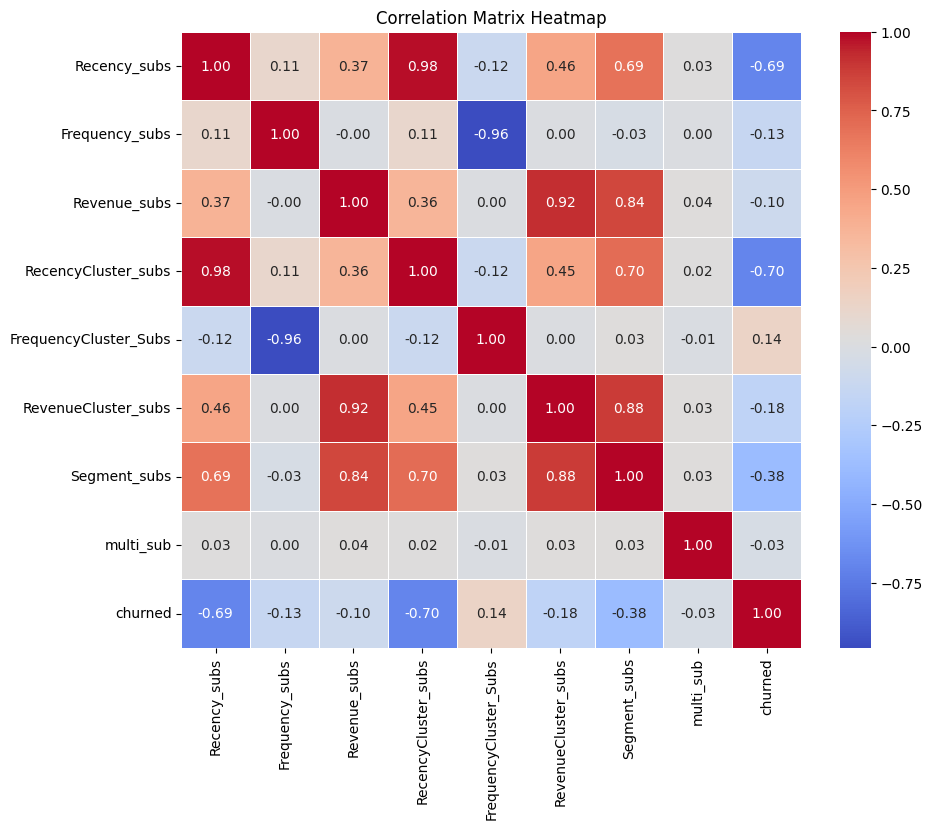

In [47]:
subs_train_2 = subs_train.drop(columns=['Capstone_id', 'Network', 'LTV_cluster'])
corr_matrix = subs_train_2.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [64]:
X_train = subs_train_2.drop(['churned', 'Recency_subs', 'RecencyCluster_subs', 'RevenueCluster_subs', 'FrequencyCluster_Subs'], axis=1)
y_train = subs_train_2['churned']

X_val = subs_val.drop(columns=['Capstone_id', 'Network', 'LTV_cluster', 'churned', 'Recency_subs', 'RecencyCluster_subs', 'RevenueCluster_subs', 'FrequencyCluster_Subs'])
y_val = subs_val['churned']

X_test = subs_test.drop(columns=['Capstone_id', 'Network', 'LTV_cluster', 'churned', 'Recency_subs', 'RecencyCluster_subs', 'RevenueCluster_subs', 'FrequencyCluster_Subs'])
y_test = subs_test['churned']

In [65]:
# Define a parameter grid for max_depth and learning_rate
param_grid = {
    'max_depth': [3, 5],        
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300]
}

# Initialize the model for binary classification
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Changed for binary classification
    n_jobs=-1, 
    min_child_weight=1,
    random_state=seed
)

# Set up GridSearchCV (include fit_params if you need to pass sample_weight)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,      # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
)

# Perform the grid search (add sample_weight here if necessary, e.g., grid_search.fit(X_train, y_train, sample_weight=weights))
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best cross-validation score:  0.9726855959775215


In [66]:
# Refit model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test[X_train.columns], y_test)
val_acc = best_model.score(X_val[X_train.columns], y_val)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(train_acc))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(test_acc))
print('Accuracy of XGB classifier on validation set: {:.2f}'.format(val_acc))

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.97
Accuracy of XGB classifier on validation set: 0.97


In [67]:
len(subs_train), len(subs_test), len(subs_val)

(67620, 14491, 14490)

In [68]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7269
           1       0.96      0.99      0.97      7222

    accuracy                           0.97     14491
   macro avg       0.97      0.97      0.97     14491
weighted avg       0.97      0.97      0.97     14491



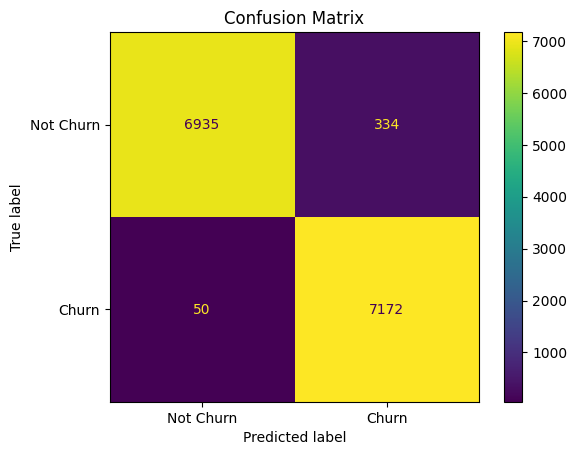

In [69]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [70]:
# Initialize the SHAP explainer with your model
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

print("SHAP values shape:", shap_values.values.shape)

SHAP values shape: (14491, 4)


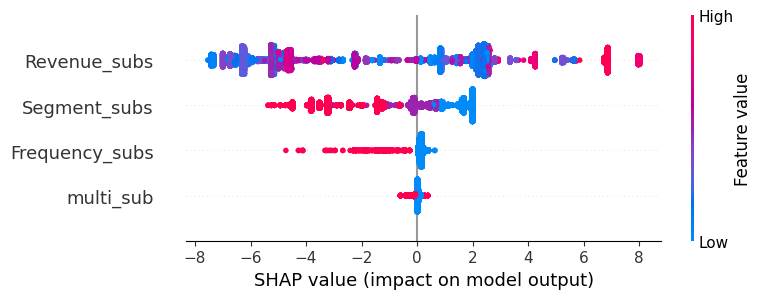

In [71]:
shap.summary_plot(shap_values.values, X_test)

In [72]:
subs_train.Recency_subs.value_counts()

Recency_subs
32     20197
150    16416
90      7125
44      3013
106     2832
       ...  
138       18
137       18
114       16
133        1
121        1
Name: count, Length: 151, dtype: int64

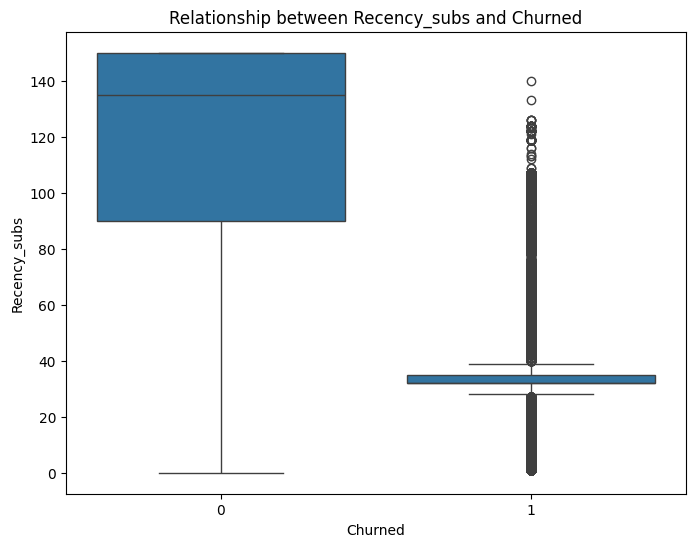

In [60]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="churned", y="Recency_subs", data=subs_train)
plt.title("Relationship between Recency_subs and Churned")
plt.xlabel("Churned")
plt.ylabel("Recency_subs")
plt.show()

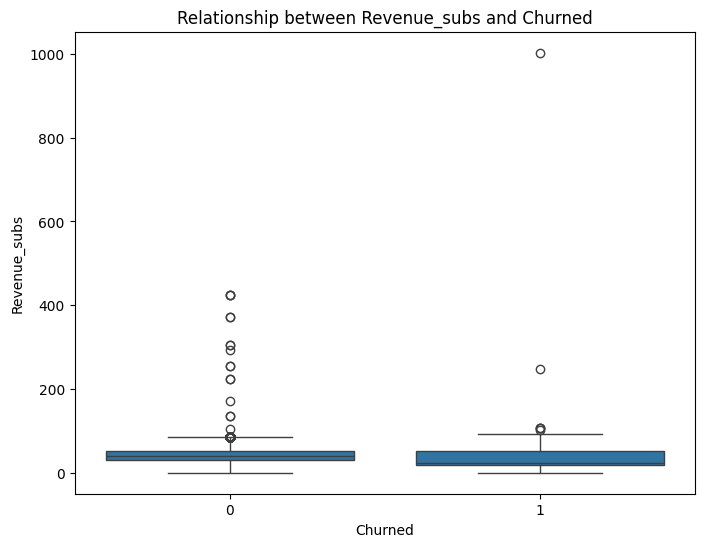

In [50]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="churned", y="Revenue_subs", data=subs_train)
plt.title("Relationship between Revenue_subs and Churned")
plt.xlabel("Churned")
plt.ylabel("Revenue_subs")
plt.show()

#### Option 2 Add Online Viewership Data

In [73]:
# One hot encoding
train_final_2 = train_final.drop(columns=['Capstone_id', 'Network', 'LTV_cluster'])
corr_matrix = train_final_2.corr()
corr_matrix

,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view,Recency_subs,Frequency_subs,Revenue_subs,RecencyCluster_subs,FrequencyCluster_Subs,RevenueCluster_subs,Segment_subs,multi_sub,churned
RECENCY_view,1.000000,-0.307777,-0.390352,-0.227056,-0.942196,-0.312925,-0.379690,-0.203339,0.001824,0.005015,-0.014747,0.002132,-0.006240,-0.014610,-0.008083,-0.001006,0.004588
FREQUENCY_view,-0.307777,1.000000,0.786323,0.742671,0.289411,0.976390,0.767271,0.627519,-0.015567,-0.016331,0.016669,-0.014073,0.016757,0.014466,0.000161,-0.002082,0.006380
TENURE_view,-0.390352,0.786323,1.000000,0.581183,0.366532,0.800796,0.965885,0.518968,-0.014359,-0.018520,0.013720,-0.013004,0.018658,0.011276,-0.001616,-0.003491,0.004389
TOTAL_WATCH_view,-0.227056,0.742671,0.581183,1.000000,0.215221,0.726024,0.568122,0.894244,-0.017951,-0.015472,0.013675,-0.016851,0.013707,0.011575,0.000035,-0.003536,0.009078
RecencyCluster_view,-0.942196,0.289411,0.366532,0.215221,1.000000,0.294047,0.360762,0.193445,-0.008018,-0.007755,0.014667,-0.008033,0.009178,0.014047,0.006800,-0.001802,0.003064
FrequencyCluster_view,-0.312925,0.976390,0.800796,0.726024,0.294047,1.000000,0.782958,0.639901,-0.016169,-0.017407,0.015586,-0.014345,0.017843,0.014045,-0.000566,-0.000985,0.005597
TenureCluster_view,-0.379690,0.767271,0.965885,0.568122,0.360762,0.782958,1.000000,0.507391,-0.014876,-0.017156,0.013788,-0.013397,0.017965,0.011962,-0.001212,-0.003848,0.006908
DurationCluster_view,-0.203339,0.627519,0.518968,0.894244,0.193445,0.639901,0.507391,1.000000,-0.014945,-0.012667,0.007588,-0.013554,0.011968,0.006445,-0.002241,0.001353,0.008058
Recency_subs,0.001824,-0.015567,-0.014359,-0.017951,-0.008018,-0.016169,-0.014876,-0.014945,1.000000,0.099886,0.355985,0.976915,-0.102856,0.451437,0.665805,0.028157,-0.690393
Frequency_subs,0.005015,-0.016331,-0.018520,-0.015472,-0.007755,-0.017407,-0.017156,-0.012667,0.099886,1.000000,-0.002247,0.100980,-0.961589,0.006242,-0.019181,-0.002886,-0.126856


In [74]:
X_train = train_final_2.drop(['churned'], axis=1)
y_train = train_final_2['churned']

X_val = val_final.drop(columns=['Capstone_id', 'Network', 'LTV_cluster', 'churned'])
y_val = val_final['churned']

X_test = test_final.drop(columns=['Capstone_id', 'Network', 'LTV_cluster', 'churned'])
y_test = test_final['churned']

In [75]:
# Define a parameter grid for max_depth and learning_rate
param_grid = {
    'max_depth': [3, 5],        
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300]
}

# Initialize the model for binary classification
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Changed for binary classification
    n_jobs=-1, 
    min_child_weight=1,
    random_state=seed
)

# Set up GridSearchCV (include fit_params if you need to pass sample_weight)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,      # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
)

# Perform the grid search (add sample_weight here if necessary, e.g., grid_search.fit(X_train, y_train, sample_weight=weights))
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best cross-validation score:  0.9861524325694949


In [76]:
# Refit model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test[X_train.columns], y_test)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(train_acc))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(test_acc))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.99


In [77]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3374
           1       0.98      0.99      0.99      3344

    accuracy                           0.99      6718
   macro avg       0.99      0.99      0.99      6718
weighted avg       0.99      0.99      0.99      6718



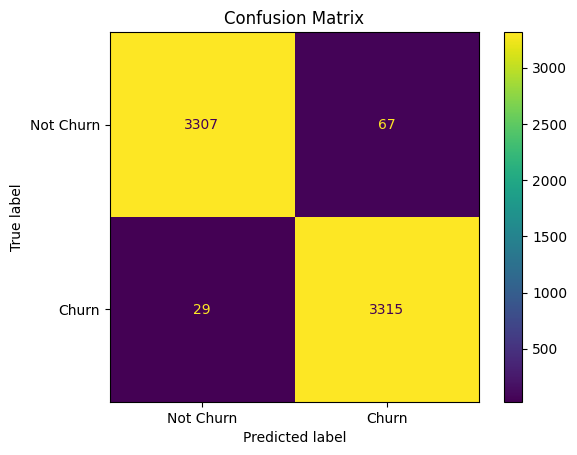

In [78]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [79]:
# Initialize the SHAP explainer with your model
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

print("SHAP values shape:", shap_values.values.shape)

SHAP values shape: (6718, 16)


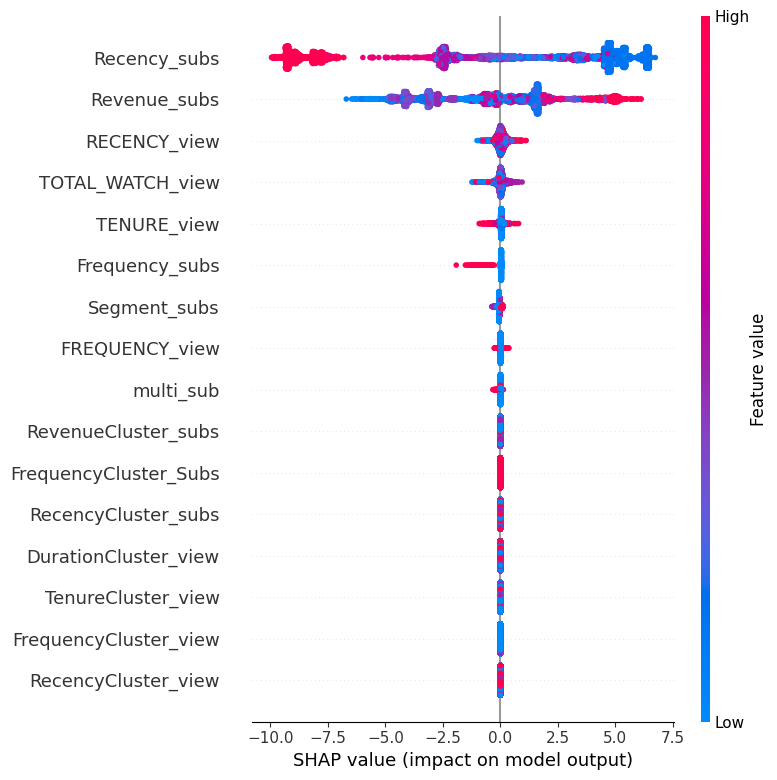

In [80]:
shap.summary_plot(shap_values.values, X_test)

### Modeling

In [79]:
train_final_ltv['LTVCluster'] = train_final_ltv['LTVCluster'].fillna(0)
train_final_ltv['OverallScore'] = (train_final_ltv.RecencyCluster_view + train_final_ltv.FrequencyCluster_view + train_final_ltv.TenureCluster_view + 2*train_final_ltv.DurationCluster_view +
                                   2 * train_final_ltv.RevenueCluster_subs + train_final_ltv.RecencyCluster_subs + train_final_ltv.FrequencyCluster_Subs)
train_final_ltv
                                   

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view,...,Frequency_subs,Revenue_subs,RevenueCluster_subs,RecencyCluster_subs,FrequencyCluster_Subs,OverallScore_subs,MultipleSubscriber,Churned,LTVCluster,OverallScore
0,AAA6935373,RETROREEL,29,1,1,65.0,2,0,0,0,...,1,19.98,0,0,2,0.4,0,1,0.0,4
1,AAA9527798,PULSE,4,1,1,86.0,2,0,0,1,...,1,7.99,0,0,2,0.4,0,1,0.0,6
2,AAB1462140,RETROREEL,0,4,151,359.0,2,2,2,2,...,1,74.88,1,2,2,1.5,0,0,0.0,16
3,AAC1231805,LIMELIGHT,150,1,1,60.0,0,0,0,0,...,1,72.99,1,1,2,1.2,0,0,0.0,5
4,AAC5319389,LIMELIGHT,84,1,1,67.0,1,0,0,0,...,1,19.98,0,0,2,0.4,0,1,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44694,ZZY8936381,PULSE,136,2,9,98.0,0,1,0,1,...,1,71.94,1,1,2,1.2,1,0,0.0,8
44695,ZZZ1490400,LIMELIGHT,0,1,1,37.0,2,0,0,0,...,1,19.98,0,0,2,0.4,0,1,0.0,4
44696,ZZZ3959037,CHILLSTREAM,140,1,1,72.0,0,0,0,1,...,1,89.90,2,2,2,2.0,0,0,0.0,10
44697,ZZZ5393557,PULSE,34,1,1,41.0,2,0,0,0,...,1,86.88,2,0,2,1.4,1,1,0.0,8


In [82]:
train_final_ltv.groupby('OverallScore')[['RECENCY_view', 'FREQUENCY_view', 'TENURE_view', 'TOTAL_WATCH_view',
                                        'Frequency_subs', 'Revenue_subs', 'Recency_subs']].mean()

,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,Frequency_subs,Revenue_subs,Recency_subs
OverallScore,,,,,,,
1,149.461538,1.000000,1.000000,28.884615,2.115385,20.171154,44.269231
2,148.782254,1.000510,1.012239,36.675166,1.023967,18.778893,32.845997
3,97.752457,1.016378,1.227890,37.095461,1.033224,20.569022,41.886757
4,93.252550,1.014680,1.267231,58.966658,1.026872,23.852981,41.271212
5,101.653169,1.090376,3.437793,71.155810,1.038732,33.438694,68.774941
6,77.834561,1.107455,4.366774,69.283019,1.046940,44.071454,76.791993
7,86.107918,1.272505,13.065618,73.245390,1.068330,54.122169,108.750542
8,95.325672,1.207470,10.216294,69.773035,1.055407,71.074459,153.031397
9,72.159544,1.343254,21.654733,83.012083,1.056836,69.103905,157.452450


In [87]:
train_final_ltv['Final_Segment'] = 'Low-Value'
train_final_ltv.loc[train_final_ltv['OverallScore'] > 6, 'Final_Segment'] = 'Mid-Value'
train_final_ltv.loc[train_final_ltv['OverallScore'] > 10, 'Final_Segment'] = 'High-Value'

In [88]:
train_final_ltv.Final_Segment.value_counts()

Final_Segment
Mid-Value     17792
Low-Value     15897
High-Value    11010
Name: count, dtype: int64

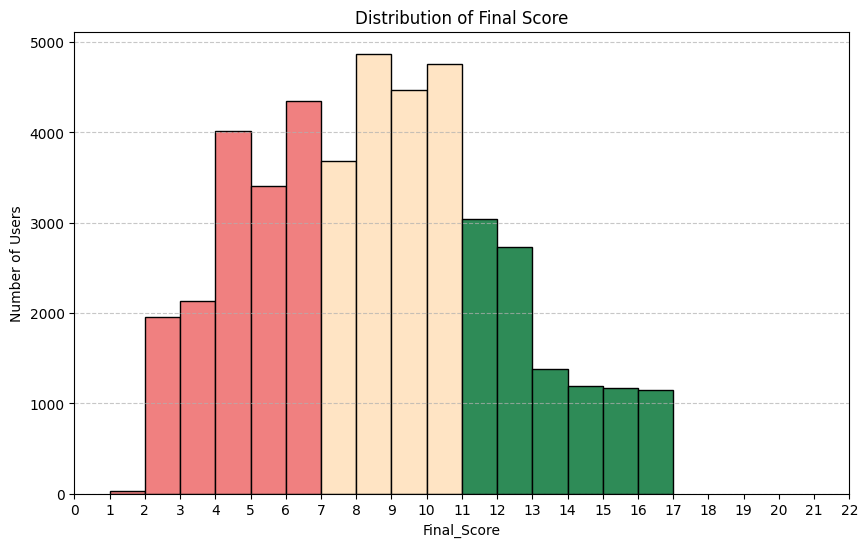

In [89]:
final_score = train_final_ltv['OverallScore']

# Define bin edges
bins = np.arange(1, 18, 1)  

# Create the histogram
plt.figure(figsize=(10, 6))
n, edges, patches = plt.hist(final_score, bins=bins, edgecolor='black')

# Assign colors based on conditions
for patch, left_edge in zip(patches, edges[:-1]):
    if left_edge < 7:
        patch.set_facecolor('lightcoral')
    elif 7 <= left_edge <= 10:
        patch.set_facecolor('bisque')
    else:
        patch.set_facecolor('seagreen')

# Add labels and grid
plt.title('Distribution of Final Score')
plt.xlabel('Final_Score')
plt.ylabel('Number of Users')
plt.xticks(range(0, 23))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [109]:
train_final_ltv

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view,...,Revenue_subs,RevenueCluster_subs,RecencyCluster_subs,FrequencyCluster_Subs,OverallScore_subs,MultipleSubscriber,Churned,LTVCluster,OverallScore,Final_Segment
0,AAA6935373,RETROREEL,29,1,1,65.0,2,0,0,0,...,19.98,0,0,2,0.4,0,1,0.0,4,Low-Value
1,AAA9527798,PULSE,4,1,1,86.0,2,0,0,1,...,7.99,0,0,2,0.4,0,1,0.0,6,Low-Value
2,AAB1462140,RETROREEL,0,4,151,359.0,2,2,2,2,...,74.88,1,2,2,1.5,0,0,0.0,16,High-Value
3,AAC1231805,LIMELIGHT,150,1,1,60.0,0,0,0,0,...,72.99,1,1,2,1.2,0,0,0.0,5,Low-Value
4,AAC5319389,LIMELIGHT,84,1,1,67.0,1,0,0,0,...,19.98,0,0,2,0.4,0,1,0.0,3,Low-Value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44694,ZZY8936381,PULSE,136,2,9,98.0,0,1,0,1,...,71.94,1,1,2,1.2,1,0,0.0,8,Mid-Value
44695,ZZZ1490400,LIMELIGHT,0,1,1,37.0,2,0,0,0,...,19.98,0,0,2,0.4,0,1,0.0,4,Low-Value
44696,ZZZ3959037,CHILLSTREAM,140,1,1,72.0,0,0,0,1,...,89.90,2,2,2,2.0,0,0,0.0,10,Mid-Value
44697,ZZZ5393557,PULSE,34,1,1,41.0,2,0,0,0,...,86.88,2,0,2,1.4,1,1,0.0,8,Mid-Value


In [121]:
df = train_final_ltv
# Rename the original 'Network' column to preserve actual values.
df = df.rename(columns={'Network': 'Network_orig'})

# Define the fixed network order.
network_order = ['RETROREEL', 'PULSE', 'LIMELIGHT', 'CINEQUEST', 'CHILLSTREAM']

# Get unique Capstone_ids.
unique_ids = df['Capstone_id'].unique()

# Create a full grid (all combinations of Capstone_id and network_order).
full_grid = pd.DataFrame([(id, net) for id in unique_ids for net in network_order],
                         columns=['Capstone_id', 'Network'])

# Merge the full grid with the original DataFrame.
# Here, we join on 'Capstone_id' and the network from the grid matching the original value.
df_merged = pd.merge(full_grid, df, left_on=['Capstone_id', 'Network'],
                     right_on=['Capstone_id', 'Network_orig'], how='left')

# Group by Capstone_id and aggregate the original network and other columns into lists.
result = df_merged.groupby('Capstone_id').agg(lambda x: list(x)).reset_index()

result

,Capstone_id,Network,Network_orig,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,...,Revenue_subs,RevenueCluster_subs,RecencyCluster_subs,FrequencyCluster_Subs,OverallScore_subs,MultipleSubscriber,Churned,LTVCluster,OverallScore,Final_Segment
0,AAA6935373,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[RETROREEL, nan, nan, nan, nan]","[29.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan]","[65.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]",...,"[19.98, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[0.4, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[4.0, nan, nan, nan, nan]","[Low-Value, nan, nan, nan, nan]"
1,AAA9527798,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[nan, PULSE, nan, nan, nan]","[nan, 4.0, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 86.0, nan, nan, nan]","[nan, 2.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]",...,"[nan, 7.99, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 2.0, nan, nan, nan]","[nan, 0.4, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 6.0, nan, nan, nan]","[nan, Low-Value, nan, nan, nan]"
2,AAB1462140,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[RETROREEL, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[4.0, nan, nan, nan, nan]","[151.0, nan, nan, nan, nan]","[359.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]",...,"[74.88, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[2.0, nan, nan, nan, nan]","[1.5, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[0.0, nan, nan, nan, nan]","[16.0, nan, nan, nan, nan]","[High-Value, nan, nan, nan, nan]"
3,AAC1231805,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[nan, nan, LIMELIGHT, nan, nan]","[nan, nan, 150.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 60.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]",...,"[nan, nan, 72.99, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 2.0, nan, nan]","[nan, nan, 1.2, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 5.0, nan, nan]","[nan, nan, Low-Value, nan, nan]"
4,AAC5319389,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[nan, nan, LIMELIGHT, nan, nan]","[nan, nan, 84.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 67.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]",...,"[nan, nan, 19.98, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 2.0, nan, nan]","[nan, nan, 0.4, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 1.0, nan, nan]","[nan, nan, 0.0, nan, nan]","[nan, nan, 3.0, nan, nan]","[nan, nan, Low-Value, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42661,ZZY8936381,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL...","[nan, PULSE, nan, nan, nan]","[nan, 136.0, nan, nan, nan]","[nan, 2.0, nan, nan, nan]","[nan, 9.0, nan, nan, nan]","[nan, 98.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]",...,"[nan, 71.94, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 2.0, nan, nan, nan]","[nan, 1.2, nan, nan, nan]","[nan, 1.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 0.0, nan, nan, nan]","[nan, 8.0, nan, nan, nan]","[nan, Mid-Value, nan, nan, nan]"
42662,ZZZ1490400,"[RETROREEL, PULSE, LIMELIGHT, CINEQUEST, CHILL

In [124]:
result['non_na_count'] = result['Network_orig'].apply(lambda x: sum(pd.notnull(item) for item in x))

result['non_na_count'].value_counts()

non_na_count
1    40707
2     1886
3       72
4        1
Name: count, dtype: int64

### Classification Model



In [94]:
# One hot encoding
df_final = train_final_ltv.drop(columns=['Capstone_id', 'Network'])
df_final_dummy = pd.get_dummies(df_final, columns=['Final_Segment'], dtype='int')
corr_matrix = df_final_dummy.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster                  1.000000
MultipleSubscriber          0.130863
Recency_subs                0.024508
RecencyCluster_subs         0.022177
OverallScore_subs           0.015958
Revenue_subs                0.013800
RevenueCluster_subs         0.010835
Frequency_subs              0.006877
Final_Segment_Mid-Value     0.006714
OverallScore                0.005758
Final_Segment_High-Value    0.001374
RecencyCluster_view         0.000553
TOTAL_WATCH_view            0.000019
RECENCY_view               -0.002220
DurationCluster_view       -0.003047
FREQUENCY_view             -0.007473
Final_Segment_Low-Value    -0.008102
FrequencyCluster_Subs      -0.008420
TenureCluster_view         -0.008524
TENURE_view                -0.009072
FrequencyCluster_view      -0.010573
Churned                    -0.028429
Name: LTVCluster, dtype: float64

In [95]:
df_final_dummy.columns

Index(['RECENCY_view', 'FREQUENCY_view', 'TENURE_view', 'TOTAL_WATCH_view',
       'RecencyCluster_view', 'FrequencyCluster_view', 'TenureCluster_view',
       'DurationCluster_view', 'Recency_subs', 'Frequency_subs',
       'Revenue_subs', 'RevenueCluster_subs', 'RecencyCluster_subs',
       'FrequencyCluster_Subs', 'OverallScore_subs', 'MultipleSubscriber',
       'Churned', 'LTVCluster', 'OverallScore', 'Final_Segment_High-Value',
       'Final_Segment_Low-Value', 'Final_Segment_Mid-Value'],
      dtype='object')

In [96]:
X = df_final_dummy.drop(['LTVCluster'], axis=1)
y = df_final_dummy['LTVCluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [105]:
# Compute weights inversely proportional to frequency:
class_counts = y_train.value_counts()
total = len(y_train)

class_weights = {cls: total/(len(class_counts)*count) for cls, count in class_counts.items()}

# Create a weight array
sample_weights = y_train.map(class_weights)

# Define a parameter grid for max_depth and learning_rate
param_grid = {
    'max_depth': [3, 5],        
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300]
}

# Initialize the model (with other desired fixed parameters)
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    n_jobs=-1, 
    min_child_weight = 1,
    random_state = seed
)

# Set up GridSearchCV
# Use fit_params to pass sample_weight to model's fit method
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
)

# Perform the grid search
grid_search.fit(X_train, y_train, **{'sample_weight': sample_weights})

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best cross-validation score:  0.9814592701009888


In [106]:
# Refit model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test[X_train.columns], y_test)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(train_acc))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(test_acc))

Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.98


In [107]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      8906
         1.0       0.00      0.00      0.00        19
         2.0       0.03      0.07      0.04        15

    accuracy                           0.98      8940
   macro avg       0.34      0.35      0.34      8940
weighted avg       0.99      0.98      0.98      8940



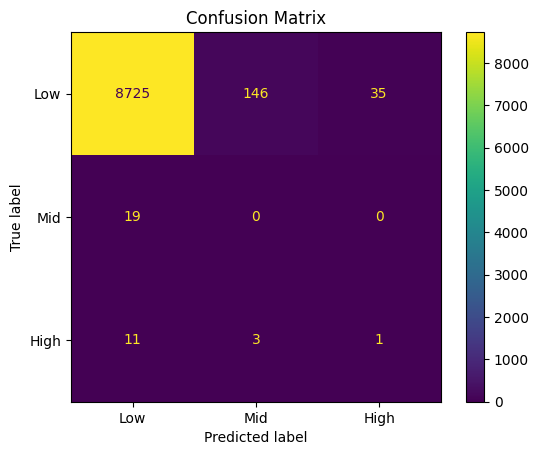

In [108]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Mid', 'High'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

### Method 3

In [24]:
view_train_final

,Capstone_id,Network,RECENCY_view,FREQUENCY_view,TENURE_view,TOTAL_WATCH_view,RecencyCluster_view,FrequencyCluster_view,TenureCluster_view,DurationCluster_view
0,AAA4562706,ChillStream,63,1,1,61.0,1,0,0,0
1,AAA4562706,HorrorHaven,73,1,1,105.0,1,0,0,1
2,AAA4562706,Lime Light,108,1,1,45.0,1,0,0,0
3,AAA4562706,StarFlix,150,1,1,82.0,0,0,0,1
4,AAA4562706,ThriTV,8,1,1,48.0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
361141,ZZZ6272754,HorrorHaven,146,1,1,61.0,0,0,0,0
361142,ZZZ6272754,Lime Light,17,2,50,27.0,2,1,1,0
361143,ZZZ6272754,RetroReel,21,1,1,37.0,2,0,0,0
361144,ZZZ8510588,ActionMax,83,1,1,99.0,1,0,0,1
